# Project - Olist Brazilian E-commerce dataset

Context
This dataset was provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on their website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, the customer gets a satisfaction survey by email where he can give a **note for the purchase experience.**
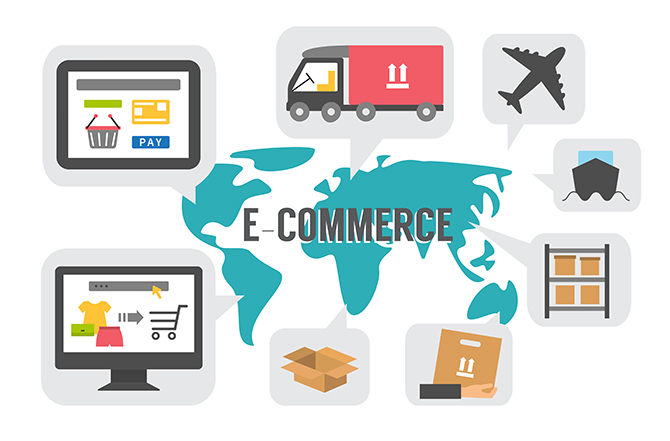


**1. Business Area Requirements:**

1.1 Customer Profiling: Understanding the customer profile.

1.2 Assessment of Ratings: Understanding our current performance in evaluations.

1.3 Area Objective: To receive predominantly 5 and 4 ratings.

**2. Purpose of the data science project:**

2.1 Developing a model to predict customer ratings.

2.2 Determine the most influential features that impact customer ratings, using interpretable/explainable machine learning models.

2.3 Implementing proactive measures to address potential low ratings

# 1. Import Libraries

In [1]:
## Connecting to Google drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install mlflow

In [4]:
pip install pyngrok

In [5]:
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.offline as py
import json
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# No warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import warnings
warnings.filterwarnings("ignore")

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 2. Merge Big Table
**The present dataset has different data sources, each table specifying a topic of e-commerce sales. The tables are separated into:**
1. Costumers
2. Geolocation
3. Orders
4. Order items
5. Payments
6. Order reviews
7. Products
8. Sellers
9. Product category name

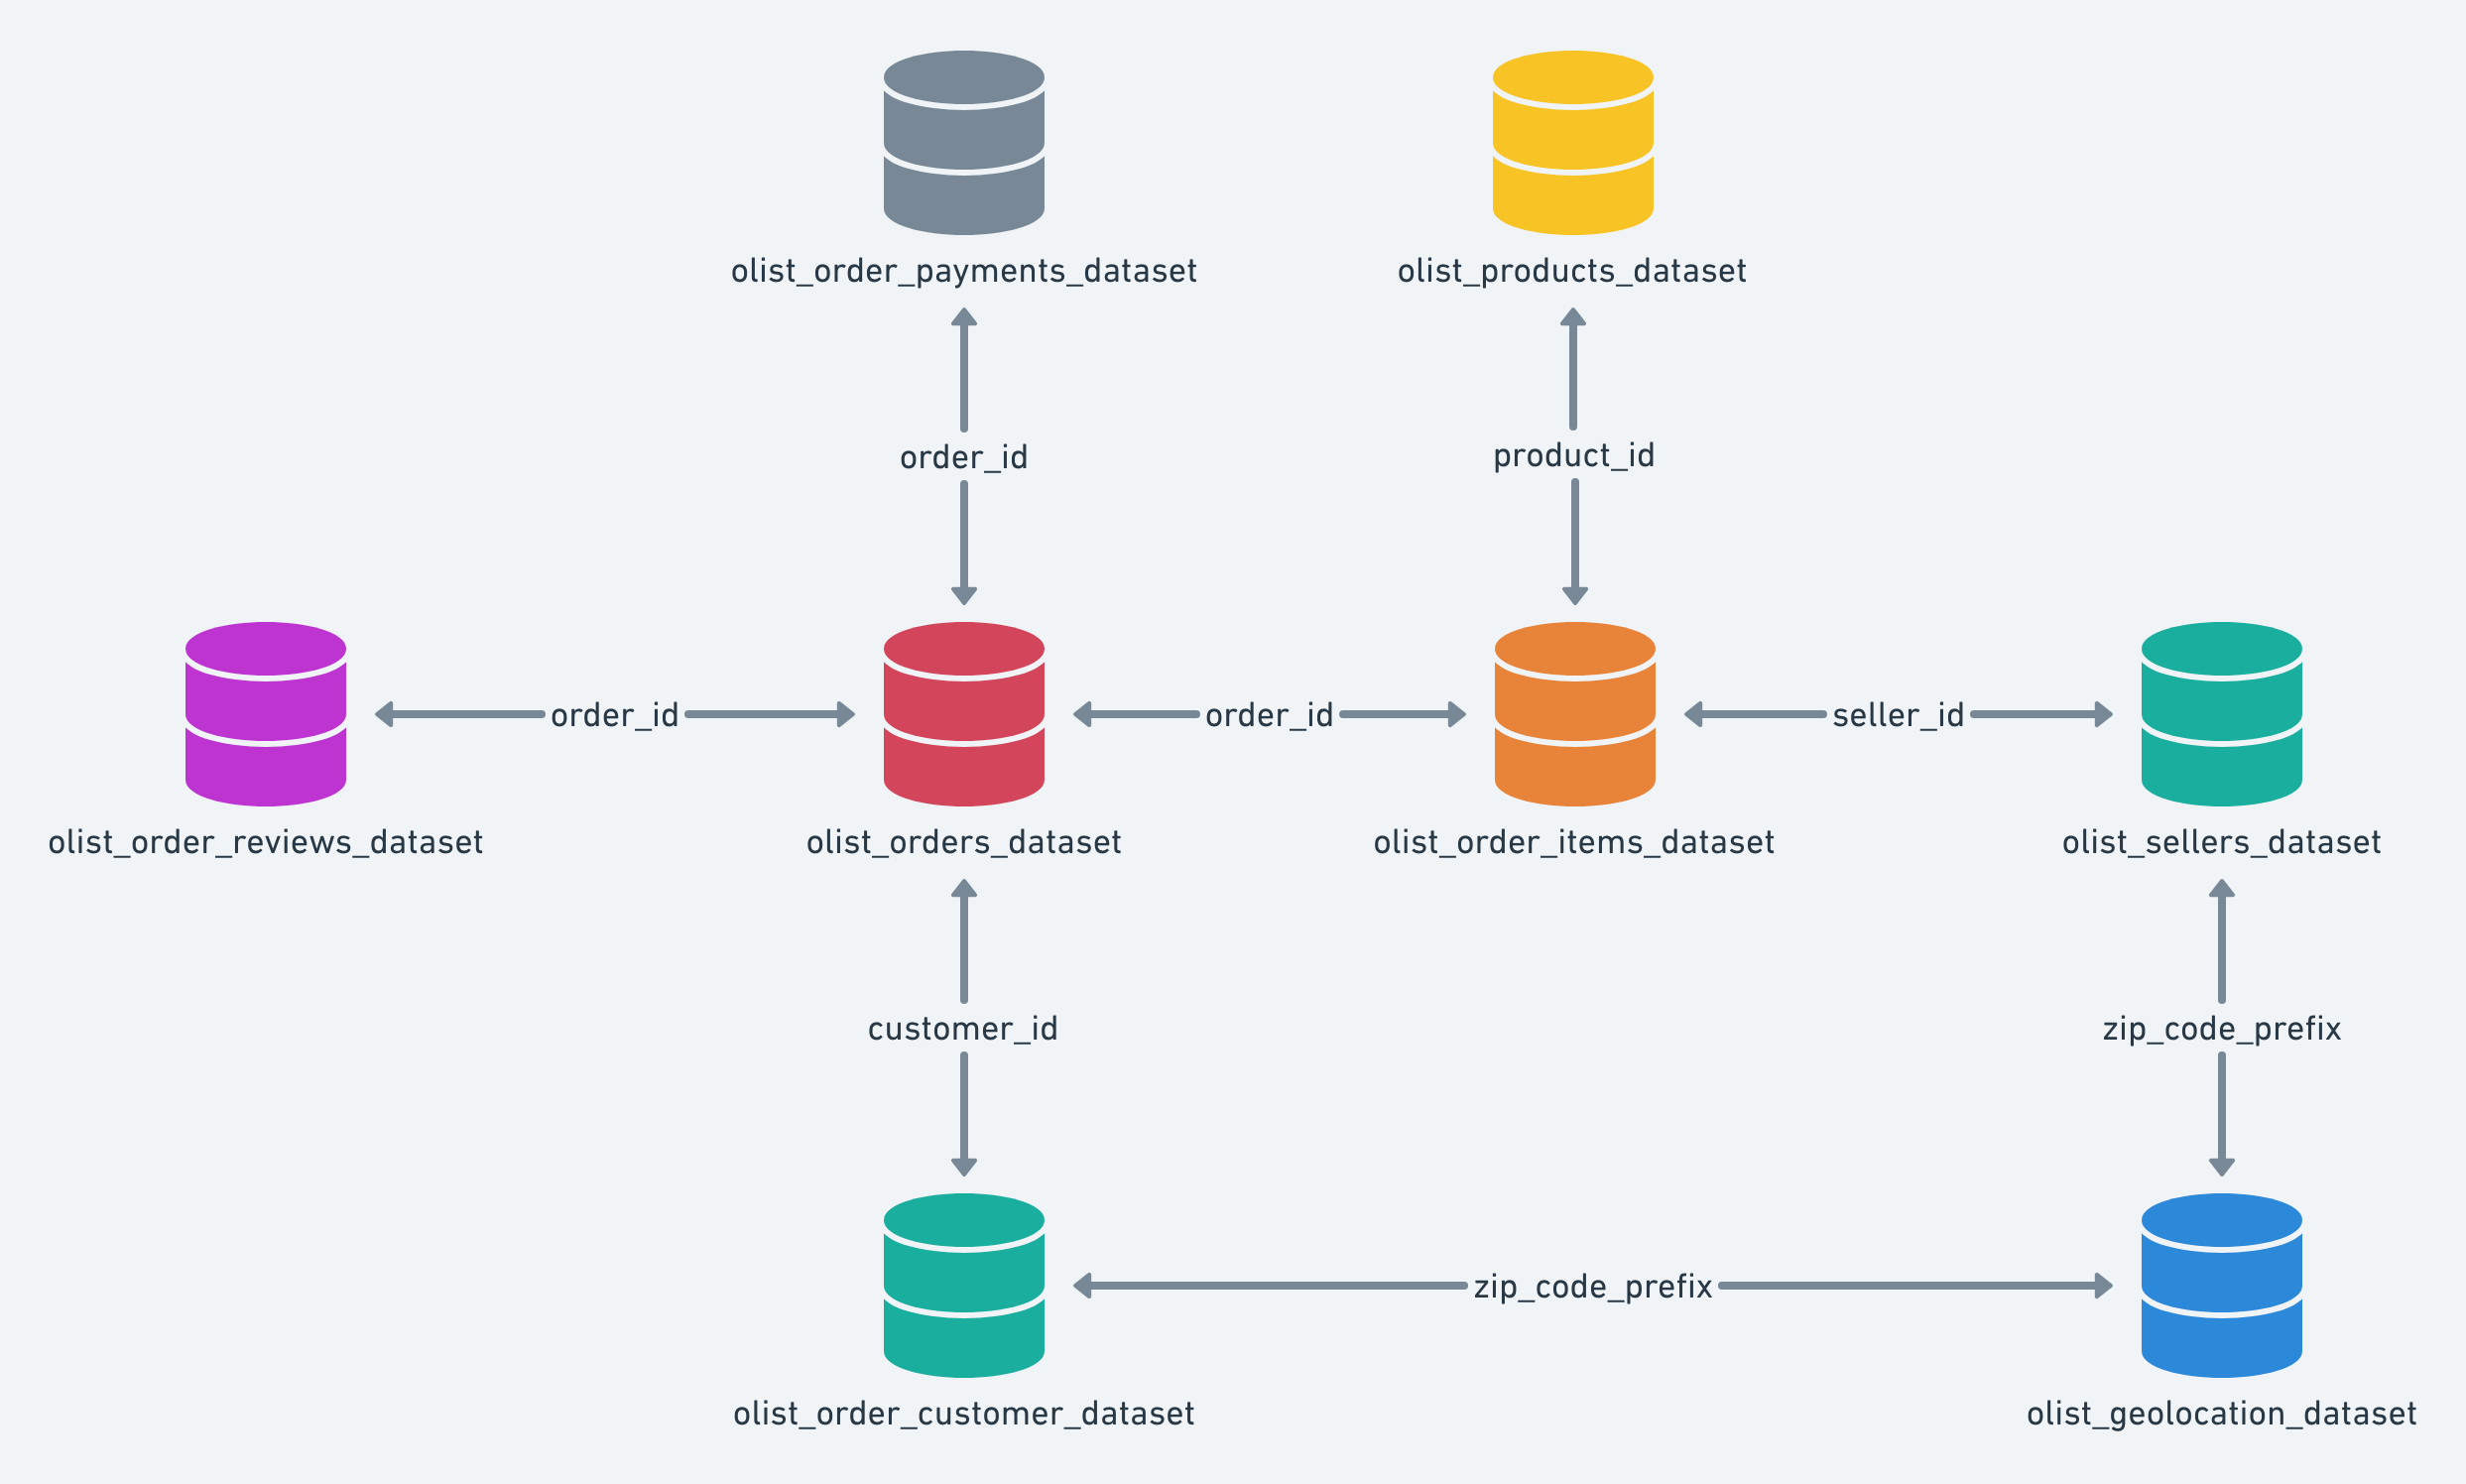

**Using SQL language I created a Big table with the union between all the tables and performed a new exploratory analysis with confrontations between the most diverse features of the dataset,** so that we can perform a full exploratory analysis of the dataset, with the following code below:

```
SELECT *
FROM customer AS c
LEFT JOIN orders AS o ON o.customer_id = c.customer_id
LEFT JOIN order_payments AS op ON op.order_id = o.order_id
LEFT JOIN order_reviews AS or2 ON or2.order_id = o.order_id
LEFT JOIN order_items AS oi ON oi.order_id = o.order_id
LEFT JOIN products AS p ON p.product_id = oi.product_id
LEFT JOIN sellers AS s ON s.seller_id = oi.seller_id;
```
The JOINS mentioned above were based on the Data Schema provided by Olist to understand the relationships and foreign keys between the tables.

Then we export the table as a CSV file called **'Olist_bigdata.csv'.**

# 4. Functions

In [7]:
def load_data(file_path, sep=',', encoding='utf-8', show_head=False):
    """
    Loads a CSV file and displays the shape of the DataFrame.

    Parameters:
    - file_path (str): path to the .csv file
    - sep (str): separator used in the CSV file (default is ',')
    - encoding (str): file encoding (default is 'utf-8')
    - show_head (bool): if True, displays the first 5 rows

    Returns:
    - df (pandas.DataFrame): the loaded DataFrame
    """
    try:
        df = pd.read_csv(file_path, sep=sep, encoding=encoding)
        print(f"✔️ Data loaded successfully: {df.shape[0]} rows × {df.shape[1]} columns.")
        if show_head:
            display(df.head())
        return df
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error loading file: {e}")


In [8]:
def convert_to_datetime(df, columns, date_format='%Y-%m-%d %H:%M:%S'):
    """
    Converts a list of DataFrame columns to datetime format.

    Parameters:
    - df (pd.DataFrame): the input DataFrame
    - columns (list): list of column names to convert
    - date_format (str): expected format of the date strings

    Returns:
    - pd.DataFrame: the updated DataFrame with converted columns
    """
    for col in columns:
        df[col] = pd.to_datetime(df[col], format=date_format, errors='coerce')
    return df

In [9]:
def split_train_test(df, target_column, test_size=0.3, random_state=10):
    """
    Splits a DataFrame into training and testing sets for features and target.

    Parameters:
    - df (pd.DataFrame): the full DataFrame
    - target_column (str): the name of the target column
    - test_size (float): proportion of the dataset to include in the test split (default is 0.3)
    - random_state (int): random seed for reproducibility (default is 10)

    Returns:
    - x_train, x_test, y_train, y_test: split datasets
    """
    x = df.drop(target_column, axis=1)
    y = df[target_column]

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=random_state
    )

    print(f"Train Data: {x_train.shape}, {y_train.shape}")
    print(f"Test Data:  {x_test.shape}, {y_test.shape}")

    return x_train, x_test, y_train, y_test

In [10]:
def log_classification_model(model_name, run_name, pipeline_model, x_train, y_train, x_test, y_test):
    with mlflow.start_run(run_name=run_name) as run:
        run_id = run.info.run_id

        # Predict
        y_pred_train = pipeline_model.predict(x_train)
        y_pred_test = pipeline_model.predict(x_test)

        # Probabilities (for ROC AUC)
        y_proba_test = pipeline_model.predict_proba(x_test)[:, 1] if hasattr(pipeline_model, "predict_proba") else None

        # Metrics
        acc = accuracy_score(y_test, y_pred_test)
        f1 = f1_score(y_test, y_pred_test)
        prec = precision_score(y_test, y_pred_test)
        recall = recall_score(y_test, y_pred_test)
        roc_auc = roc_auc_score(y_test, y_proba_test) if y_proba_test is not None else None

        # Params
        mlflow.log_param("model_type", model_name)

        # Metrics
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", recall)
        if roc_auc is not None:
            mlflow.log_metric("roc_auc", roc_auc)

        # Prepare input example and signature (for model serving)
        input_example = x_test.head()
        output_example = pipeline_model.predict(input_example)
        signature = infer_signature(input_example, output_example)

        # Log the full pipeline
        mlflow.sklearn.log_model(
            pipeline_model,
            name="model",
            input_example=input_example,
            signature=signature
        )

        # print(f"[MLflow] {model_name} → accuracy: {acc:.3f} | f1: {f1:.3f} | ROC AUC: {roc_auc:.3f}")
        print(f"[MLflow] Run ID: {run_id}")
        return run_id


# 3. Read Data

In [11]:
df = load_data('/content/drive/MyDrive/Colab Notebooks/Olist_project/main_project/data/Olist_bigdata.csv', sep=',')
df.head()

✔️ Data loaded successfully: 108510 rows × 38 columns.


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1.0,credit_card,2.0,146.87,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1.0,credit_card,8.0,335.48,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,88303.0,itajai,SC
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1.0,credit_card,7.0,157.73,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,8577.0,itaquaquecetuba,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1.0,credit_card,1.0,173.30,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,8577.0,itaquaquecetuba,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1.0,credit_card,8.0,252.25,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,casa_conforto,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,14940.0,ibitinga,SP


## 3.1 Data Description

In [12]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

df.info()

Number of rows: 108510
Number of columns: 38
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108510 entries, 0 to 108509
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    108510 non-null  object 
 1   customer_unique_id             108510 non-null  object 
 2   customer_zip_code_prefix       108510 non-null  int64  
 3   customer_city                  108510 non-null  object 
 4   customer_state                 108510 non-null  object 
 5   order_id                       108510 non-null  object 
 6   order_status                   108510 non-null  object 
 7   order_purchase_timestamp       108510 non-null  object 
 8   order_approved_at              108334 non-null  object 
 9   order_delivered_carrier_date   106591 non-null  object 
 10  order_delivered_customer_date  105314 non-null  object 
 11  order_estimated_delivery_date  108510 non-null

In [13]:
#Analysis of statistical distributions
describe_data = df[['payment_value', 'review_score', 'price', 'freight_value', 'product_photos_qty']]
describe_data.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_value,108509.0,157.450174,219.569973,0.00,57.70,102.14,176.15,13664.08
review_score,108510.0,4.040144,1.382331,1.00,4.00,5.00,5.00,5.00
price,107677.0,124.348378,189.402854,0.85,40.00,78.00,139.00,6735.00
freight_value,107677.0,20.151918,15.926436,0.00,13.14,16.35,21.25,409.68
product_photos_qty,106113.0,2.235409,1.739785,1.00,1.00,2.00,3.00,20.00


# 4. Data Cleaning and Preprocessing

## 4.1 Data Transformation

In [14]:
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'review_creation_date',
    'review_answer_timestamp',
    'shipping_limit_date'
]

df = convert_to_datetime(df, date_columns)

# 5.Exploratory Data Analysis

## 5.1 **Analyzing the Top 10 Customers by payment value**: Which customer has the highest accumulated purchase value?

In [15]:
df_top_customers = df.groupby('customer_unique_id').payment_value.sum().reset_index().sort_values(by='payment_value', ascending = False).head(10)
df_top_customers

,customer_unique_id,payment_value
10376,1b76903617af13189607a36b0469f6f3,15978.65
3826,0a0a92112bd4c708ca5fde585afaa872,13664.08
81722,d97b3cfb22b0d6b25ac9ed4e9c2d481b,10437.58
26456,46450c74a0d8c5ca9395da1daac6c120,9553.02
75528,c8ed31310fc440a3f8031b177f9842c3,9258.24
60913,a229eba70ec1c2abef51f04987deb7a5,8891.00
19539,33de26d1fafbfd4945eb586f7136efe6,8697.99
2418,066ee6b9c6fc284260ff9a1274a82ca7,8530.14
81962,da122df9eeddfedc1dc1f5349a1a690c,7571.63
44447,763c8b1c9c68a0229c42c9fc6f662b93,7274.88


In [16]:
#Plotly - 10 top customers by payment value
plotly_1 = go.Bar(x = df_top_customers['customer_unique_id'],
                  y = df_top_customers['payment_value'],
                  name = 'Top 10 Customers by payment value',
                  marker = {'color': '#1f77b4'})

layout = go.Layout(title='Top 10 Customers by payment value',
                   xaxis={'title': 'Customer unique ID'},
                   yaxis={'title': 'Payment value'},
                   width=1050,
                   height=700)


df_plotly_1 = [plotly_1]
fig = go.Figure (data = df_plotly_1, layout = layout)
fig.show()

## 5.2 **Customer Region with highest sales**: In which Brazilian region has the highest accumulated payment value in the dataset?

In [17]:
#Sales by state

sales_per_state = df.groupby('customer_state').payment_value.sum().reset_index().sort_values(by='payment_value', ascending = False)
sales_per_state.head()

,customer_state,payment_value
25,SP,6434668.51
18,RJ,2283135.35
10,MG,1991391.94
22,RS,949413.59
17,PR,862487.01


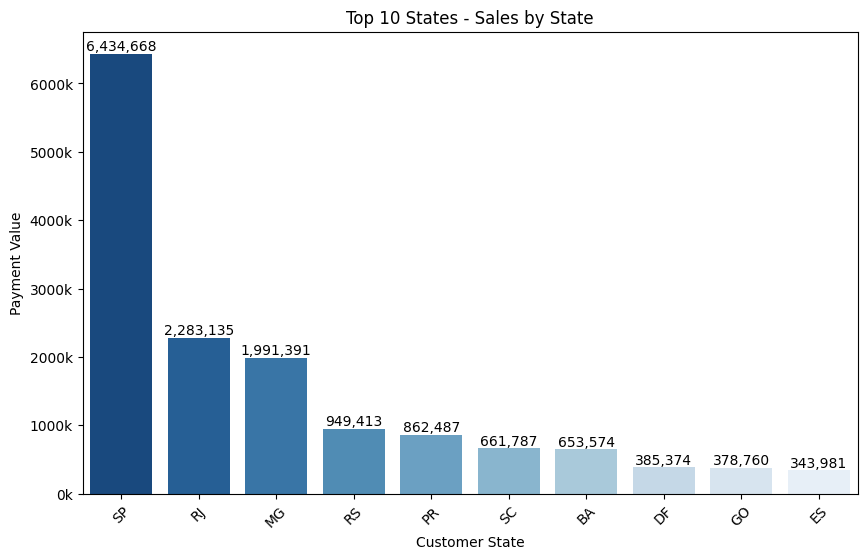

In [18]:
top_10_states = sales_per_state.head(10)

# Definindo a paleta de cores em tons de azul
colors = sns.color_palette('Blues_r', n_colors=10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top_10_states, x='customer_state', y='payment_value', palette=colors)
plt.xlabel('Customer State')
plt.ylabel('Payment Value')
plt.title('Top 10 States - Sales by State')
plt.xticks(rotation=45)

# Formatando os rótulos no eixo Y
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))

# Adicionando rótulos de dados acima das barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()


In [19]:
#Plot map
br_states = '/content/drive/MyDrive/Colab Notebooks/Olist_project/main_project/data/br_states.json'
geo_json_data = json.load(open(br_states))

fig = px.choropleth(sales_per_state,
                    geojson = geo_json_data,
                    locations = 'customer_state',
                    featureidkey = 'id',
                    projection = 'mercator',
                    color = 'payment_value',
                    labels = {'payment_value': 'Sales'})

fig.update_geos(fitbounds='geojson', visible = True)
fig.update_layout (margin={'r': 0, 't':0, 'l': 0, 'b':0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## 5.3 **Order purchase month**: The business area is also interested in understanding in which month we have the highest sales and if there is a month that we are below average?

In [20]:
#Creating a new columns with the Month vision

df['order_purchase_month'] = df.order_purchase_timestamp.dt.to_period('M').astype(str)

# How much sales per month?
sales_per_month = df.groupby(by = 'order_purchase_month').payment_value.sum()

# Color palette by mean values of sales
mean = sales_per_month.values.mean()
color = []

for i in sales_per_month.values:
    if i < mean:
        color.append('red')
    else:
        color.append('skyblue')

#Plotly: If the sale value is lower than the average = red

df_sales_month = go.Bar (x = sales_per_month.index,
                         y = sales_per_month.values,
                         marker = {'color': color,
                                   'line': {'color': '#300', 'width':1}})

layout = go.Layout (title = 'Sales per month',
                    xaxis = {'title':'Month'},
                    yaxis = {'title':'Payment values'},
                    width=1050,
                   height=700)

fig = go.Figure (data = df_sales_month, layout = layout)
fig.show()

## 5.4 **Amount of Sales by product category**: On which product category do we have the highest cumulative payment amounts?

In [21]:
category_values = df.groupby(by = 'product_category_name').payment_value.sum().sort_values(ascending = False).head(10)
category_values

,payment_value
product_category_name,
beleza_saude,1499983.39
cama_mesa_banho,1480753.49
relogios_presentes,1352516.31
esporte_lazer,1210833.55
informatica_acessorios,1157699.18
moveis_decoracao,1032484.17
utilidades_domesticas,826768.36
cool_stuff,738400.90
automotivo,720204.05


In [22]:
df_category_values = go.Bar (x = category_values.index,
                            y = category_values.values,
                            marker = {'color': 'lightgreen',
                                   'line': {'color': '#300', 'width':1}})

layout = go.Layout (title = 'Total sales value by category product',
                    xaxis = {'title':'Product category'},
                    yaxis = {'title':'Payment values'},
                    width=1050,
                   height=700)

fig = go.Figure (data = df_category_values, layout = layout)
fig.show()

**Payment type**: What is the most used payment method on our platform?

In [23]:
df['payment_type'].value_counts()

,count
payment_type,
credit_card,80241
boleto,20597
voucher,6069
debit_card,1599
not_defined,3


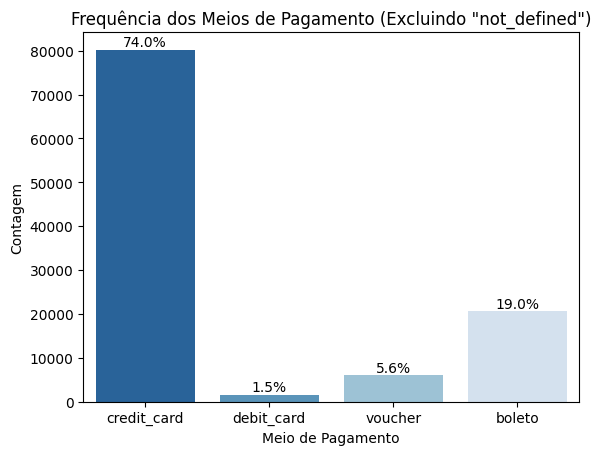

In [24]:
# Filtrando os dados e excluindo os valores "not_defined"
df_filtered = df[df['payment_type'] != 'not_defined']

# Calculando a porcentagem de cada meio de pagamento em relação ao total
#payment_percentages = df_filtered['payment_type'].value_counts(normalize=True) * 100

# Criando o gráfico de contagem
ax = sns.countplot(data=df_filtered, x='payment_type', palette='Blues_r')

# Adicionando os rótulos de contagem em cima de cada barra (porcentagem em relação ao total)
total = len(df_filtered)
for p in ax.patches:
    percentage = f"{p.get_height() / total * 100:.1f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Definindo os rótulos dos eixos
plt.xlabel('Meio de Pagamento')
plt.ylabel('Contagem')

# Definindo o título do gráfico
plt.title('Frequência dos Meios de Pagamento (Excluindo "not_defined")')

# Exibindo o gráfico
plt.show()


## 5.5 **Review Score**: Which review score do we receive the most about our sales?

In [25]:
#Top score on reviews of Olist orders
review_counts = df.groupby('review_score').review_id.count().reset_index().sort_values(by='review_id', ascending = False).set_index('review_score')
review_counts

,review_id
review_score,
5,61554
4,20595
1,13546
3,9070
2,3745


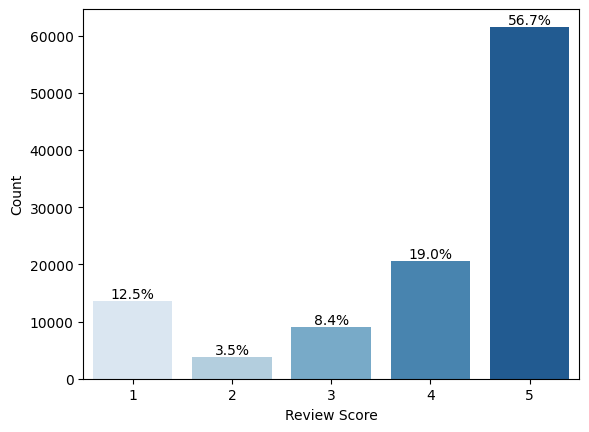

In [26]:
# Definindo uma paleta de cores em escala de azuis
colors = sns.color_palette('Blues', len(review_counts))

# Criando o gráfico de barras
ax = sns.barplot(x=review_counts.index, y='review_id', data=review_counts, palette=colors)

# Adicionando os rótulos de contagem em cima de cada barra

for p in ax.patches:
    percentage = f"{p.get_height() / total * 100:.1f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Definindo os rótulos dos eixos
plt.xlabel('Review Score')
plt.ylabel('Count')

# Exibindo o gráfico
plt.show()


## 5.6 Correlation between features

In [27]:
# Calculate differences in days
df['estimated_delivery_time'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days

df['real_delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

In [28]:
# Booleano: if real_delivery <= estimated delivery = 1 else 0
#So, '1' its good because it was delivered on time.

df.loc[df['real_delivery_time'] <= df['estimated_delivery_time'], 'delivery_on_time'] = 1
df.loc[df['real_delivery_time'] > df['estimated_delivery_time'], 'delivery_on_time'] = 0

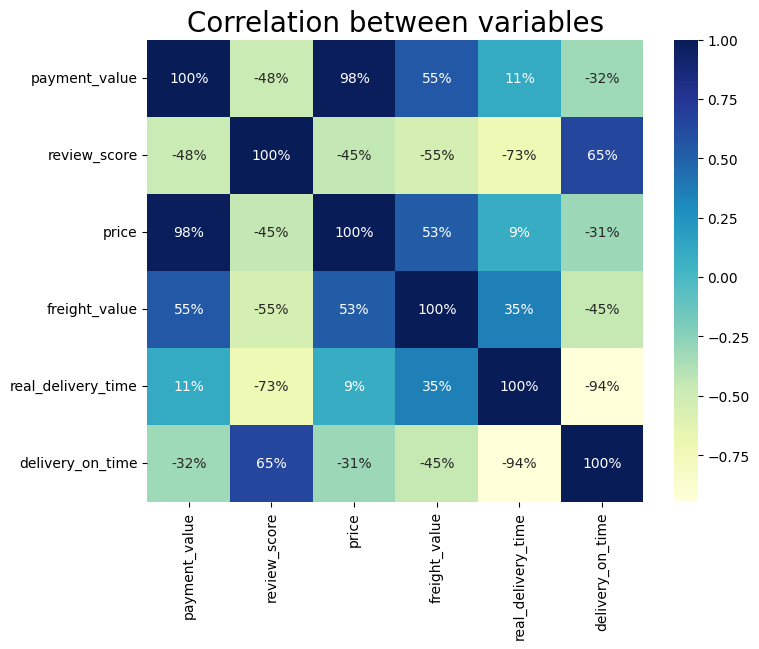

In [29]:
corr = df[['payment_value', 'review_score', 'price', 'freight_value', 'real_delivery_time','delivery_on_time']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr.corr(), annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Correlation between variables', fontsize = 20);

**Delivery time are the features with most strongly correlated** with the review score (our target).

In [30]:
df_aux = sales_per_state = df.groupby('review_score').delivery_on_time.mean().reset_index().sort_values(by='review_score', ascending = False)

fig = px.scatter (df_aux, x = 'review_score', y = 'delivery_on_time',
                 size = 'review_score', color = 'delivery_on_time',
                 hover_name = 'review_score', size_max = 50,
                 color_continuous_scale='Blues')

fig.update_layout(width=1050, height=700)

fig.show()

# 6. Feature Engineering

To improve model performance, we will generate **new features** inspired by the strong correlation between **delivery status and review scores.**


## 6.1 **Delivery time:** We will now create a set of delivery time-related features to capture the impact of logistics on customer satisfaction.

In [31]:
# The order was delayed or not
df['delivery_delay_days'] = (df['real_delivery_time'] - df['estimated_delivery_time'])

df['is_late'] = (df['delivery_delay_days'] > 0).astype(int)

In [32]:
# The order was delayed in shipping or not
df['shipping_delay_days'] = (df['order_delivered_carrier_date'] - df['order_purchase_timestamp']).dt.days

In [33]:
df['was_delivered'] = df['order_status'].apply(lambda x: 1 if x == 'delivered' else 0)


## 6.2 **Review Score:** seller reputation

In [34]:
seller_reputation = df.groupby('seller_id')['review_score'].mean().reset_index()
seller_reputation.rename(columns={'review_score': 'seller_reputation'}, inplace=True)

df = df.merge(seller_reputation, on='seller_id', how='left')


In [35]:
df[['order_delivered_customer_date','order_approved_at', 'estimated_delivery_time', 'real_delivery_time', 'delivery_delay_days', 'is_late', 'shipping_delay_days','seller_reputation','review_score', 'delivery_on_time']].head()

,order_delivered_customer_date,order_approved_at,estimated_delivery_time,real_delivery_time,delivery_delay_days,is_late,shipping_delay_days,seller_reputation,review_score,delivery_on_time
0,2017-05-25 10:35:35,2017-05-16 15:22:12,19,8.0,-11.0,0,6.0,3.486137,4,1.0
1,2018-01-29 12:41:19,2018-01-12 20:58:32,24,16.0,-8.0,0,2.0,4.260870,5,1.0
2,2018-06-14 17:58:51,2018-05-20 16:19:10,24,26.0,2.0,1,22.0,3.486137,5,0.0
3,2018-03-28 16:04:25,2018-03-13 17:29:19,27,14.0,-13.0,0,14.0,3.486137,5,1.0
4,2018-08-09 20:55:48,2018-07-29 10:10:09,16,11.0,-5.0,0,1.0,3.789834,5,1.0


# 7. Modeling

## 7.1 Target variable

**First, we will create the response variable for the classification model that will be discussed.**

Since the business area has informed us that **the target is review scores 4 and 5, we will label this range as '1' and the ranges below as '0'.**

The goal of the project will be to determine whether a given customer **is likely to give a good or bad review.**

In [36]:
# Copy of df for modeling process
df_model = df.copy()

In [37]:
# Creation of the target variable

df_model['review_score'] = df_model['review_score'].apply(lambda x: 1 if x > 3 else 0)

In [38]:
# Selecion
df_model = df_model[['customer_state',
                     'order_status',
                     'payment_type',
                     'payment_installments',
                     'payment_value',
                     'price',
                     'freight_value',
                     'product_category_name',
                     'product_description_lenght',
                     'product_photos_qty',
                     'product_weight_g',
                     'product_length_cm',
                     'product_height_cm',
                     'product_width_cm',
                     'order_purchase_timestamp',
                     'real_delivery_time',
                     'delivery_on_time',
                     'estimated_delivery_time',
                     'delivery_delay_days',
                     'is_late',
                     'was_delivered',
                     'shipping_delay_days',
                     'seller_reputation',
                     'review_score']]

# 8. Machine Learning

## 8.1 Train test split

In [39]:
from sklearn.model_selection import train_test_split

# Separating the features (independent variables) and the target (dependent variable)
x = df_model.drop('review_score', axis=1)  # Features
y = df_model['review_score']  # Target

# Train and test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

print(f"Train Data: {x_train.shape}, {y_train.shape}")
print(f"Test Data: {x_test.shape}, {y_test.shape}")

Train Data: (75957, 23), (75957,)
Test Data: (32553, 23), (32553,)


## 8.2 Features

In [40]:
# Features numéricas
numerical_features = x_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Features categóricas
categorical_features = x_train.select_dtypes(include=['object', 'category']).columns.tolist()


In [41]:
numerical_features

['payment_installments',
 'payment_value',
 'price',
 'freight_value',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'real_delivery_time',
 'delivery_on_time',
 'estimated_delivery_time',
 'delivery_delay_days',
 'is_late',
 'was_delivered',
 'shipping_delay_days',
 'seller_reputation']

In [42]:
categorical_features

['customer_state', 'order_status', 'payment_type', 'product_category_name']

## 8.3 Random Forest Pipeline

In [43]:
pip install category_encoders

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder

# Categorical pipeline with TargetEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder(handle_unknown='value', handle_missing='value'))])

# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Combine both
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('num', numeric_transformer, numerical_features)
])

# Final pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestClassifier(random_state=10))
])


In [45]:
# Training model
pipeline_rf.fit(x_train, y_train)

# Predict on training set
rf_train_predictions = pipeline_rf.predict(x_train)

# Predict on test set
rf_test_predictions = pipeline_rf.predict(x_test)

In [46]:
from sklearn.metrics import classification_report

print("Test Classification Report:")
print(classification_report(y_test, rf_test_predictions))


Test Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.39      0.52      8076
           1       0.83      0.97      0.89     24477

    accuracy                           0.82     32553
   macro avg       0.81      0.68      0.71     32553
weighted avg       0.82      0.82      0.80     32553



**Performance metrics**

**Accuracy**: measures the **proportion of correctly classified instances** out of the total number of instances in a classification problem. It provides an overall assessment of the model's correctness in predicting the classes of the samples.

In [47]:
from sklearn.metrics import accuracy_score

# Train Accuracy
rf_train_accuracy = accuracy_score(y_train, rf_train_predictions)
print("Random Forest Train model accuracy:", rf_train_accuracy)

# Test Accuracy
rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)
print("Random Forest Test model accuracy:", rf_test_accuracy)


Random Forest Train model accuracy: 0.9990257645773266
Random Forest Test model accuracy: 0.8223512425890087


**Confusion Matrix**

[[ 3131  4945]
 [  838 23639]]


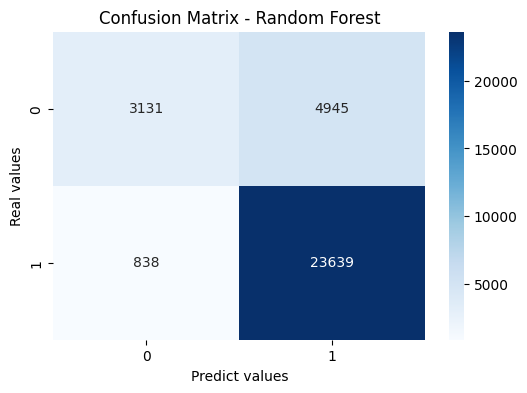

In [48]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculating the confusion matrix
rf_cm = confusion_matrix(y_test, rf_test_predictions)
print(rf_cm)


# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predict values')
plt.ylabel('Real values')
plt.show()

**Precision**: is the proportion of **true positive predictions out of the total instances predicted as positive**. It measures the accuracy of positive predictions and helps assess the model's ability to **avoid false positives**.

In [49]:
#Precision
from sklearn.metrics import precision_score

# Train Precision score of classifier
rf_train_precision = precision_score(y_train, rf_train_predictions)

print("Precision Train Score of the Random Forest classifier is:", rf_train_precision)

# Test Precision score of classifier
rf_test_precision = precision_score(y_test, rf_test_predictions)

print("Precision Test Score of the Random Forest classifier is:", rf_test_precision)

Precision Train Score of the Random Forest classifier is: 0.9991161178509532
Precision Test Score of the Random Forest classifier is: 0.8270011195074167


**Recall:** Recall, also known as sensitivity or true positive rate, is the proportion of **true positive predictions out of all actual positive instances**. It measures the model's ability to identify and capture all positive cases, **minimizing false negatives.**

In [50]:
#Sensitivy (Recall)
from sklearn.metrics import recall_score

# Calculating the Train recall score of classifier
rf_train_recall = recall_score(y_train, rf_train_predictions)
print("Train Recall Score of the Random Forest classifier is:", rf_train_recall)

# Calculating the Test recall score of classifier
rf_test_recall = recall_score(y_test, rf_test_predictions)
print("Test Recall Score of the Random Forest classifier is:", rf_test_recall)

Train Recall Score of the Random Forest classifier is: 0.9996011929532529
Test Recall Score of the Random Forest classifier is: 0.9657637782407975


**F1-score**: combines precision and recall into a single value, providing a **balanced measure** of a model's performance. It is the harmonic mean of precision and recall.

In [51]:
from sklearn.metrics import f1_score

# Train F1 score of classifier
rf_train_f1_score = f1_score(y_train, rf_train_predictions)
print(f"F1 Score of the Random Forest classifier is:", rf_train_f1_score)


# Test F1 score of classifier
rf_test_f1_score = f1_score(y_test, rf_test_predictions)
print(f"F1 Score of the Random Forest classifier is:", rf_test_f1_score)

F1 Score of the Random Forest classifier is: 0.9993585965398883
F1 Score of the Random Forest classifier is: 0.8910122312055936


**ROC Curv and Auc:**

AUC for our classifier is: 0.7740127934032257


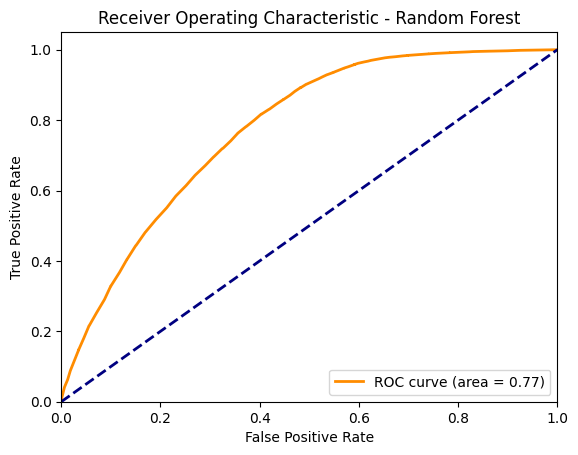

In [52]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Calculating and displaying the ROC curve for the Random Forest model
rf_probabilities = pipeline_rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_probabilities)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc_rf}")


plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.show()

## 8.4 XGBoost

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier


# Pipeline for preprocessing categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder(handle_unknown='value', handle_missing='value'))])

# Pipeline for preprocessing of numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

# ColumnTransformer for applying pipelines to corresponding columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)])

# Creating the XGBoost model
xgb_model = XGBClassifier(random_state=10)

# Apply preprocessing and apply XGBoost
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)])

In [54]:
# Training model
pipeline_xgb.fit(x_train, y_train)

# Predict train
xgb_train_predictions = pipeline_xgb.predict(x_train)


# Predict test
xgb_test_predictions = pipeline_xgb.predict(x_test)

In [55]:
from sklearn.metrics import classification_report

print("Test Classification Report:")
print(classification_report(y_test, xgb_test_predictions))


Test Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.36      0.49      8076
           1       0.82      0.96      0.89     24477

    accuracy                           0.81     32553
   macro avg       0.79      0.66      0.69     32553
weighted avg       0.80      0.81      0.79     32553



**Performance Metrics - XGBoost**

**Accuracy**

In [56]:
# Train Accuracy
xgb_train_accuracy = accuracy_score(y_train, xgb_train_predictions)
print("XGBoost Train model accuracy:", xgb_train_accuracy)

# Train Accuracy
xgb_test_accuracy = accuracy_score(y_test, xgb_test_predictions)
print("XGBoost Test model accuracy:", xgb_test_accuracy)

XGBoost Train model accuracy: 0.8462814487144042
XGBoost Test model accuracy: 0.8126747150800233


**Confusion Matrix:**

[[ 2919  5157]
 [  941 23536]]


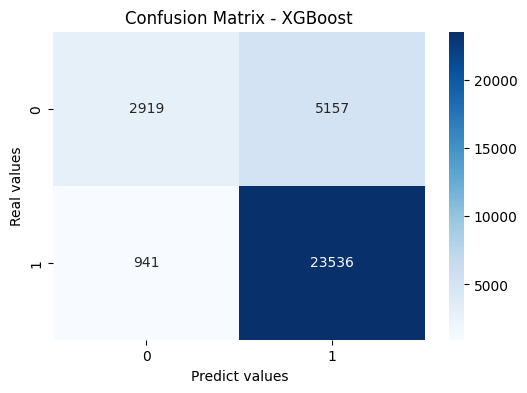

In [57]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculating the confusion matrix
rf_cm = confusion_matrix(y_test, xgb_test_predictions)
print(rf_cm)


# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predict values')
plt.ylabel('Real values')
plt.show()

**Precision:**

In [58]:
#Precision
from sklearn.metrics import precision_score

# Train precision score of Xgboost
xgb_train_precision = precision_score(y_train, xgb_train_predictions)
print("Train Precision Score of the XGB classifier is:", xgb_train_precision)


# Test precision score of Xgboost
xgb_test_precision = precision_score(y_test, xgb_test_predictions)
print("Test Precision Score of the XGB classifier is:", xgb_test_precision)

Train Precision Score of the XGB classifier is: 0.8430489260143198
Test Precision Score of the XGB classifier is: 0.8202697522043704


**Recall:**

In [59]:
#Sensitivy (Recall)
from sklearn.metrics import recall_score


# Train Recall score of classifier
xgb_train_recall = recall_score(y_train, xgb_train_predictions)
print("Train Recall Score of the XGB classifier is:", xgb_train_recall )


# Calculating the recall score of classifier
xgb_test_recall = recall_score(y_test, xgb_test_predictions)
print("Test Recall Score of the XGB classifier is:", xgb_test_recall)

Train Recall Score of the XGB classifier is: 0.9799902899153835
Test Recall Score of the XGB classifier is: 0.9615557462107285


**F1-Score:**

In [60]:
from sklearn.metrics import f1_score

# Calculating the Train F1 score of classifier
xgb_train_f1_score = f1_score(y_train, xgb_train_predictions)
print("Train F1 Score of the XGB classifier is:", xgb_train_f1_score)


# Calculating the Test F1 score of classifier
xgb_test_f1_score = f1_score(y_test, xgb_test_predictions)
print("Test F1 Score of the XGB classifier is:", xgb_test_f1_score)

Train F1 Score of the XGB classifier is: 0.906376290974405
Test F1 Score of the XGB classifier is: 0.8853112657513635


**Curva ROC-AUC:**

AUC for our classifier is: 0.7676863506092781


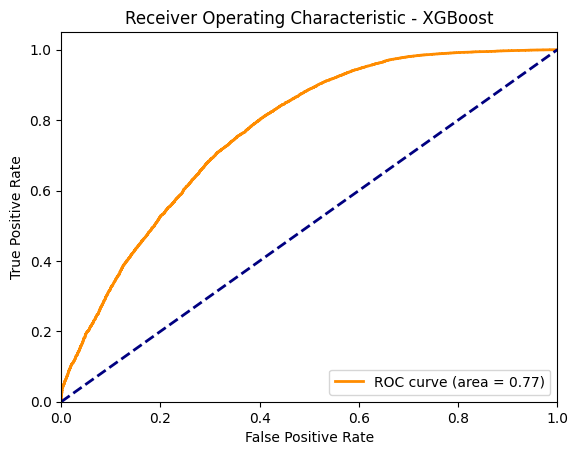

In [61]:
# Calculando e exibindo a curva ROC para o modelo XGBoost
xgb_probabilities = pipeline_xgb.predict_proba(x_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_probabilities)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc_xgb}")


plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc="lower right")
plt.show()


## 8.5 Comparing both classifiers

In [62]:
# Dataframe with the metrics
data_models = {
    'Modelo': ['Random Forest', 'XGBoost'],
    'Acurácia': [rf_test_accuracy, xgb_test_accuracy],
    'Precisão': [rf_test_precision, xgb_test_precision],
    'F1-score': [rf_test_f1_score, xgb_test_f1_score],
    'ROC AUC':  [roc_auc_rf, roc_auc_xgb]
}

df_metrics = pd.DataFrame(data_models)

# Print
print(df_metrics)


          Modelo  Acurácia  Precisão  F1-score   ROC AUC
0  Random Forest  0.822351  0.827001  0.891012  0.774013
1        XGBoost  0.812675  0.820270  0.885311  0.767686


Both models, Random Forest and XGBoost, yielded similar results in terms of accuracy, precision, F1-score, and ROC AUC.
However, when considering factors such as training time and scalability, XGBoost has a slight advantage. On average, XGBoost tends to have faster training times compared to Random Forest, thanks to its optimized boosting algorithm.

Moreover, **XGBoost is designed to handle large datasets efficiently and can take advantage of distributed computing resources to speed up training**. While both models are scalable, XGBoost's design and implementation make it better suited for handling large volumes of data.


XGBoost utilizes regularization techniques and gradual fitting to control overfitting, resulting in improved generalization on test data. Additionally, XGBoost's has the ability to **gradually adjust to the data and correct errors can lead to a smaller difference between training and test metrics, indicating more consistent performance and better generalization capability.**

Therefore, if **time and scalability are important considerations, XGBoost may be a preferable choice.** However, it's always advisable to conduct tests and adjustments with your specific data and resources to evaluate the efficiency and performance of each model.

## 8.6 Feature Importance - Shap Values - XGBoost

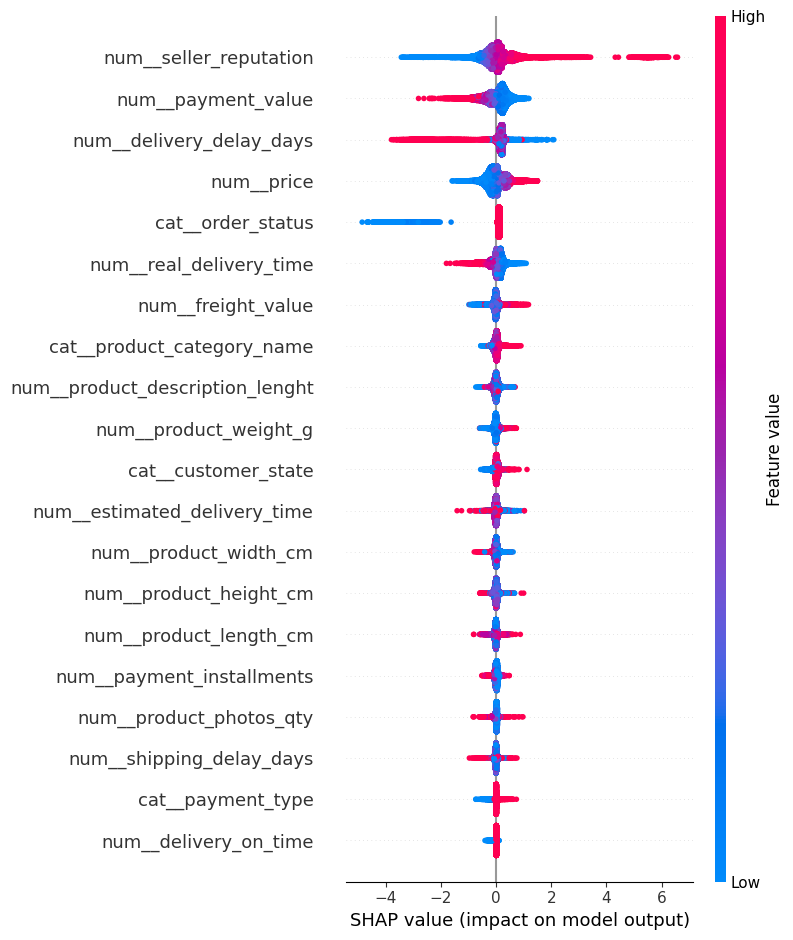

In [63]:
import shap
import matplotlib.pyplot as plt

# Step 1: Rebuild feature names manually
transformed_feature_names = (
    [f"cat__{col}" for col in categorical_features] +
    [f"num__{col}" for col in numerical_features]
)

# Step 2: Transform test set with preprocessor
x_test_transformed = pipeline_xgb.named_steps['preprocessor'].transform(x_test)

# Step 3: Create SHAP explainer (assumes XGBClassifier)
explainer = shap.Explainer(pipeline_xgb.named_steps['model'])

# Step 4: Compute SHAP values
shap_values = explainer(x_test_transformed)

# Step 5: Plot SHAP summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, x_test_transformed, feature_names=transformed_feature_names)


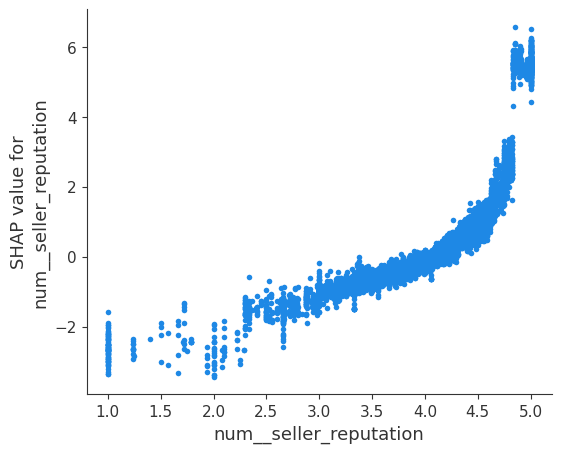

In [64]:
# Selecionar a feature para o gráfico de dependência
shap.dependence_plot('num__seller_reputation', shap_values.values, x_test_transformed, feature_names=transformed_feature_names,
                                                                                     interaction_index=None)

**Model Explainability with SHAP**
SHAP (SHapley Additive exPlanations) helps us understand how each feature contributes to a machine learning model's predictions. It assigns a value (positive or negative) to each feature, indicating its impact on increasing or decreasing the predicted outcome.

In the summary plot, we see that **seller_reputation** is the most influential feature affecting the model's output — higher reputation scores consistently push predictions upward. The dependence plot confirms this relationship, showing a clear upward trend: as **seller reputation increases, so does the predicted review score.**

💡 **Business Insight**
This suggests that improving seller reputation on the Olist marketplace — through better service, faster shipping, or fewer complaints — could lead to higher customer satisfaction (measured as review score). Business strategies could include training sellers, offering incentives for good behavior, or penalizing poor performance.

**Saving the model in a Pickle object**

In [65]:
import pickle

# Salvar o modelo em um arquivo usando pickle
filename =  '/content/drive/MyDrive/Colab Notebooks/Olist_project/pipeline_xgb.pkl'
pickle.dump(pipeline_xgb, open(filename, 'wb'))

# 9. Model Deployment: MLflow + FastAPI


In this section, we´ll combine **MLflow** and **FastAPI** to serve a trained machine learning model in production.

- **MLflow** is used to track experiments, manage the model registry, and load the final model version marked as `@production`.
- **FastAPI** is used to create a REST API that receives prediction requests in JSON format, validates the input, and returns model predictions as a JSON response.
- The service is configured to run inside a Jupyter/Colab environment by using threading and `nest_asyncio`, allowing API testing directly from the notebook.

This setup simulates a lightweight **MLOps deployment pipeline where the model lifecycle (tracking → registry → serving) and the serving infrastructure are connected.**


## 9.1 MLflow

## 9.1.1 Experiment tracking

**Step 1:** Set Up MLflow Tracking with **SQLite & Ngrok**.
We configure MLflow to use a local SQLite database and expose the UI via ngrok for public access from Colab.

In [81]:
import mlflow
import subprocess
from pyngrok import ngrok, conf
import getpass

# Define the MLflow tracking URI with SQLite
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

# Start MLflow UI in background
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", MLFLOW_TRACKING_URI, "--port", "5000"])

# Set MLflow tracking URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# Set or create experiment
mlflow.set_experiment("O_List_Project_reviewscore_prediction")

<Experiment: artifact_location='/content/mlruns/1', creation_time=1754835195782, experiment_id='1', last_update_time=1754835195782, lifecycle_stage='active', name='O_List_Project_reviewscore_prediction', tags={}>

**Step 2:** Authenticate and Start Ngrok Tunnel

In [82]:
#print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/setup")
#conf.get_default().auth_token = getpass.getpass()

# Expose MLflow UI via ngrok
port = 5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel "{public_url}" -> "http://127.0.0.1:{port}"')

 * ngrok tunnel "https://a13e93e86288.ngrok-free.app" -> "http://127.0.0.1:5000"


**Step 3:** Log Trained Models to MLflow. Each run will appear in the MLflow UI under the chosen experiment. You can compare metrics and parameters between models.

In [69]:
run_id_rf = log_classification_model("Random Forest",
                                    "RandomForest_run1", #run name
                                     pipeline_rf,    #trained model
                                     x_train,
                                     y_train,
                                     x_test,
                                     y_test)

run_id_xgb = log_classification_model("XGBoost",
                                      "XGBoost_run1",
                                      pipeline_xgb,
                                      x_train,
                                      y_train,
                                      x_test,
                                      y_test)

[MLflow] Run ID: 95d63c5f25e54ad19101b52276f3b234
[MLflow] Run ID: c61ca671bba84d4ab7e7f43ca6ee2d8f


## 9.1.2 Model Registry

In [70]:
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri("sqlite:///mlflow.db")
client = MlflowClient()

run_id = run_id_xgb
model_name = "review_score_classifier"

# Registry
result = mlflow.register_model(model_uri=f"runs:/{run_id}/model",
                              name=model_name)

model_version = result.version

2025/08/10 14:32:02 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/10 14:32:02 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
Registered model 'review_score_classifier' already exists. Creating a new version of this model...
2025/08/10 14:32:02 WARNING mlflow.tracking._model_registry.fluent: Run with id c61ca671bba84d4ab7e7f43ca6ee2d8f has no artifacts at artifact path 'model', registering model based on models:/m-1b1549f875a042509121aaab834318c4 instead
Created version '2' of model 'review_score_classifier'.


In [71]:
# Promote to Production
client.transition_model_version_stage(name="review_score_classifier",
                                      version=model_version,
                                      stage="Production",
                                      archive_existing_versions=True)


client.set_registered_model_alias(name=model_name,
                                  alias="production",
                                  version=model_version)

print(f"Model {model_name} v{model_version} registered, promoted, and aliased @production")

Model review_score_classifier v2 registered, promoted, and aliased @production


**Getting the saved model in @production to make a prediction**

In [72]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}@production")


sample = x_test.head(5).copy()

preds = model.predict(sample)

print("Sample shape:", sample.shape)
print("Predictions:", preds)

Sample shape: (5, 23)
Predictions: [1 1 1 1 0]


# 10. Fast API

**Serving the MLflow Model via API**

After training and registering our model in MLflow (and promoting it to the `@production` stage), the next step is to make it accessible for real-time predictions.  
We will achieve this by creating a REST API using **FastAPI**, which will:

- **Load the latest production model** directly from the MLflow Model Registry.  
- **Expose endpoints** for health checks and predictions.  
- **Accept JSON inputs** that match the model's expected schema.  
- **Return predictions** in real-time, enabling integration with external systems or applications.

By deploying our model as an API, we bridge the gap between model training and actual usage in production, allowing other services to send data and receive predictions without direct access to the training environment.


In [1]:
import threading
import nest_asyncio, uvicorn
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List, Dict

nest_asyncio.apply()

# Name and stage of the model registry
MODEL_NAME = "review_score_classifier"
MODEL_STAGE = "Production"
model = mlflow.pyfunc.load_model(f"models:/{MODEL_NAME}@production")

# Define data schema and FastAPI app
class PredictPayload(BaseModel):
    records: List[Dict]

app = FastAPI(title="Review Score Prediction API (Notebook)", version="1.0")

@app.get("/")
def home():
    return {"status": "ok", "model": MODEL_NAME, "alias": "@production"}

@app.post("/predict")
def predict(payload: PredictPayload):
    df = pd.DataFrame(payload.records)

    # Mapping columns to predict
    cast_map = {
        "payment_installments": "float64",
        "payment_value": "float64",
        "price": "float64",
        "freight_value": "float64",
        "product_description_lenght": "float64",
        "product_photos_qty": "float64",
        "product_weight_g": "float64",
        "product_length_cm": "float64",
        "product_height_cm": "float64",
        "product_width_cm": "float64",
        "real_delivery_time": "float64",
        "delivery_on_time": "float64",
        "estimated_delivery_time": "int64",
        "delivery_delay_days": "float64",
        "is_late": "int64",
        "was_delivered": "int64",
        "shipping_delay_days": "float64",
        "seller_reputation": "float64",
    }


    cols_to_cast = {c: t for c, t in cast_map.items() if c in df.columns}
    df = df.astype(cols_to_cast)

    # Convert datetime
    if "order_purchase_timestamp" in df.columns:
        df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

    preds = model.predict(df)
    return {"predictions": preds.tolist()}

# start server function
def start_server():
    uvicorn.run(app, host="0.0.0.0", port=8090, log_level="info")

# open public url
public_url = ngrok.connect(8090).public_url
print("Public API URL:", public_url)

# uvicorn in background server
thread = threading.Thread(target=start_server, daemon=True)
thread.start()


ModuleNotFoundError: No module named 'mlflow'

**API Prediction Flow**

The FastAPI service acts as a bridge between incoming requests and the MLflow model stored in the Model Registry.  
The flow is as follows:

1. **Client sends data**:  
   A client application (e.g., another service, a frontend app, or a script) sends a JSON payload to the `/predict` endpoint.

2. **FastAPI processes request**:  
   - Validates the JSON structure.  
   - Converts the incoming data into a Pandas DataFrame.  
   - Ensures the data types match the model's input schema.

3. **MLflow model inference**:  
   - Loads the latest `@production` model from the MLflow Model Registry.  
   - Uses the model to generate predictions for the given input.

4. **Return response**:  
   - Sends the predictions back to the client as JSON.  
   - The client can then use these predictions in its workflow.

In [106]:
import requests

API_URL = public_url

payload = {
  "records": [
    {
      "customer_state": "MS",
      "order_status": "delivered",
      "payment_type": "boleto",
      "payment_installments": 1.0,              # float
      "payment_value": 49.3,
      "price": 29.9,
      "freight_value": 19.4,
      "product_category_name": "esporte_lazer",
      "product_description_lenght": 509.0,
      "product_photos_qty": 2.0,
      "product_weight_g": 650.0,
      "product_length_cm": 22.0,
      "product_height_cm": 12.0,
      "product_width_cm": 22.0,
      "order_purchase_timestamp": "2018-07-02T23:55:31",
      "real_delivery_time": 8.0,
      "delivery_on_time": 1.0,
      "estimated_delivery_time": 23,
      "delivery_delay_days": -15.0,
      "is_late": 0,
      "was_delivered": 1,
      "shipping_delay_days": 1.0,
      "seller_reputation": 4.5333333333
    }
  ]
}

r = requests.post(f"{API_URL}/predict", json=payload)
print(r.status_code, r.json())


INFO:     35.194.133.220:0 - "POST /predict HTTP/1.1" 200 OK
200 {'predictions': [0]}
